In [91]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import os
np.set_printoptions(threshold=np.inf)

In [92]:
capacity_constraint_dir = "../../capacity_constraint_map_logs/alibaba_discrete_1_d_100"

scheduler_heatmap = {}
for file_name in os.listdir(capacity_constraint_dir):
    scheduler_time = int(file_name.split("_", 1)[1].split(".", 1)[0])
    with open(os.path.join(capacity_constraint_dir, file_name), "r") as f:
        usage_map = {}
        for line in f:
            key, val = line.strip().split(": ")
            _, worker_time = key.split("_", 1)
            worker, time = worker_time.split("_at_")
            # print(f"{file_name} worker: {worker} time: {time} {val.split(', ')[0]}")
            usage_map[int(time)] = int(val.split(", ")[0])
    scheduler_heatmap[scheduler_time] = usage_map

In [93]:
granularity = 1
min_planahead, max_planahead = float("inf"), 0
scheduler_times = []
for scheduler_time in sorted(scheduler_heatmap.keys()):
    if len(scheduler_heatmap[scheduler_time]) > 0:
        scheduler_times.append(scheduler_time)
        min_planahead_this_cycle = min(scheduler_heatmap[scheduler_time].keys())
        max_planahead_this_cycle = max(scheduler_heatmap[scheduler_time].keys())
        # print(
        #     f"min_planahead: {min_planahead_this_cycle} max_planahead_this_cycle: {max_planahead_this_cycle}"
        # )
        if min_planahead_this_cycle < min_planahead:
            min_planahead = min_planahead_this_cycle
        if max_planahead_this_cycle > max_planahead:
            max_planahead = max_planahead_this_cycle
print(f"max_plan_ahead: {max_planahead}, min_plan_ahead: {min_planahead}")
min_planahead = 1
num_slots = int(((max_planahead - min_planahead) / granularity) + 1)
print(f"Number of slots: {num_slots}")

max_plan_ahead: 2184, min_plan_ahead: 6
Number of slots: 2184


In [94]:
occupancy_map = np.zeros((len(scheduler_heatmap), num_slots + 1))
# scheduler_times = list(sorted(scheduler_heatmap.keys()))
for index, key in enumerate(scheduler_times):
    for slot_time in sorted(scheduler_heatmap[key].keys()):
        occupancy_map[index][int(slot_time / granularity)] = scheduler_heatmap[key][
            slot_time
        ]
     

[0.0, '10 (Max)', 20.0, 30.0, 40.0, 50.0]


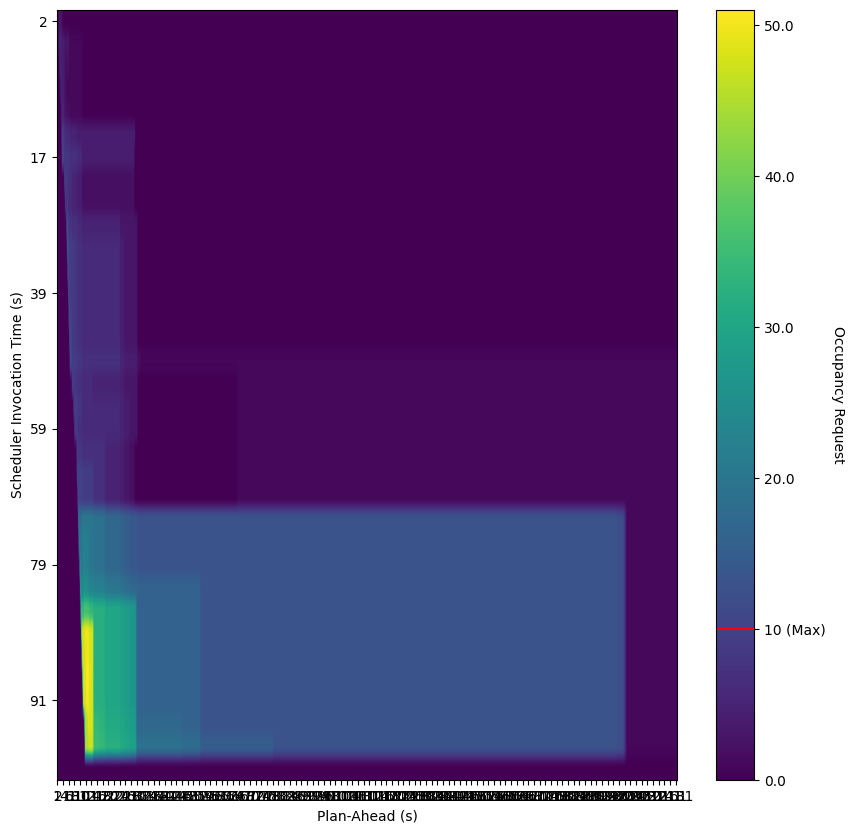

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(occupancy_map, aspect="auto")

ax.set_yticks(np.arange(occupancy_map.shape[0])[::6], labels=scheduler_times[::6])
ax.set_xticks(
    np.arange(occupancy_map.shape[1])[::20],
    labels=list(range(min_planahead, max_planahead + 1, granularity))[::20],
)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Occupancy Request", rotation=-90, va="bottom")
cbar.ax.axhline(y=10, c="r")
original_ticks = list(cbar.get_ticks())[:-1]
cbar.set_ticks(original_ticks)
labels = [tick if tick != 10 else "10 (Max)" for tick in original_ticks]
print(labels)
cbar.set_ticklabels(labels)
ax.set_xlabel("Plan-Ahead (s)")
ax.set_ylabel("Scheduler Invocation Time (s)")
plt.savefig("occupancy_request_heatmap_scheduler_discretization_10.jpg")

In [143]:
import math
def get_predictor(
    predictor_type, max_discretization, min_discretization, max_occupancy
):
    max_value = max_discretization
    min_value = min_discretization
    total_steps = max_occupancy
    if predictor_type == "linear":
        def linear_decay(t):
            return max_value - (max_value - min_value) * t / total_steps
        return linear_decay
    elif predictor_type == "cosine":
        def cosine_decay(t):
            return min_value + 0.5 * (max_value - min_value) * (
                1 + math.cos(t / total_steps * math.pi)
            )
        return cosine_decay
    return None

In [144]:
max_discretization = 5
max_occupancy = 50
alpha = 0.1
min_discretization = 1
cosine_predictor = get_predictor(
    "cosine",
    max_occupancy=max_occupancy,
    max_discretization=max_discretization,
    min_discretization=min_discretization,
)
linear_predictor = get_predictor(
    "linear",
    max_occupancy=max_occupancy,
    max_discretization=max_discretization,
    min_discretization=min_discretization,
)

[5, 5, 5, 4, 4, 2, 1, 1, 1]
[5, 5, 4, 4, 3, 2, 1, 1, 1]


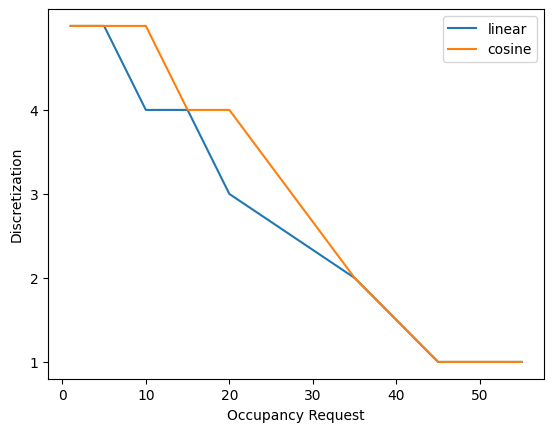

In [145]:
xvals = [1, 5, 10, 15, 20, 35, 45, 50, 55]
yvals_linear = [round(max(linear_predictor(x), 1)) for x in xvals]
yvals_cosine = [round(max(cosine_predictor(x), 1)) for x in xvals]

plt.plot(xvals, yvals_linear, label="linear")
plt.plot(xvals, yvals_cosine, label="cosine")

plt.xlabel("Occupancy Request")
plt.ylabel("Discretization")
plt.yticks(list(range(min_discretization, max_discretization)))
plt.legend()
print(yvals_cosine)
print(yvals_linear)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(occupancy_map, aspect="auto")

In [146]:
predictor_based_dyn_discretization = {}
predictors = {"linear": linear_predictor, "cosine": cosine_predictor}
target_index = -3
target_occupancy_map = occupancy_map[target_index]
size = target_occupancy_map.shape[0]
print(f"size: {size}")
discretizations = {}
for predictor_key in predictors:
    predictor = predictors[predictor_key]
    dynamic_discretization = []
    for i in range(size):
        if len(dynamic_discretization) > 0 and i < dynamic_discretization[-1][0][1]:
            continue
        current_occupancy = target_occupancy_map[i]
        p_discretization = round(max(predictor(current_occupancy), 1))
        next_len = min(i + p_discretization, size)
        while next_len >= (i + 1):
            p_avg_discretization = round(
                predictor(np.average(target_occupancy_map[i:next_len]))
            )
            if p_avg_discretization == p_discretization:
                dynamic_discretization.append(((i, next_len), (next_len - i)))
                break
            next_len -= 1
    discretizations[predictor_key] = dynamic_discretization

size: 2185


In [147]:
def get_discretizations(discretizations):
    ret = []
    for (start,end),window in discretizations:
        discretization = [window for _ in range(start, end)]
        ret +=  discretization
    return ret

In [161]:
tt_occupancy_map = occupancy_map[target_index].reshape(1,size)

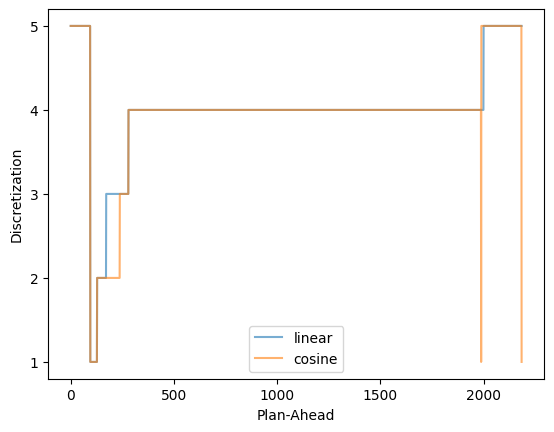

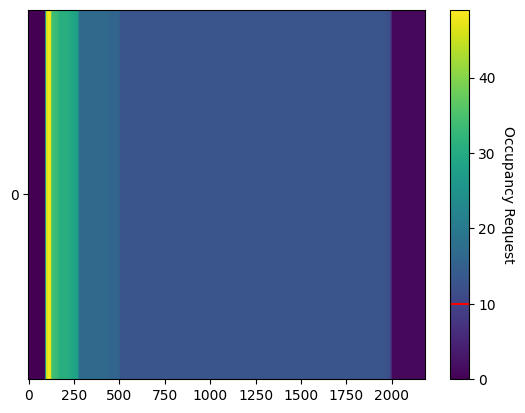

In [166]:
fig, axs = plt.subplots(nrows=2)
x = list(range(size))
for predictor_key in predictors:
    axs[0].plot(
        x,
        get_discretizations(discretizations[predictor_key]),
        label=predictor_key,
        alpha=0.6,
    )
# predictor_key="cosine"
# plt.plot(x, get_discretizations(discretizations[predictor_key]), label=predictor_key)
axs[0].set_xlabel("Plan-Ahead")
axs[0].set_ylabel("Discretization")
plt.yticks([1, 2, 3, 4, 5])
plt.legend()

im = ax.imshow(tt_occupancy_map, aspect="auto")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Occupancy Request", rotation=-90, va="bottom")
cbar.ax.axhline(y=10, c="r")
original_ticks = list(cbar.get_ticks())[:-1]
cbar.set_ticks(original_ticks)
ax.set_yticks([0])

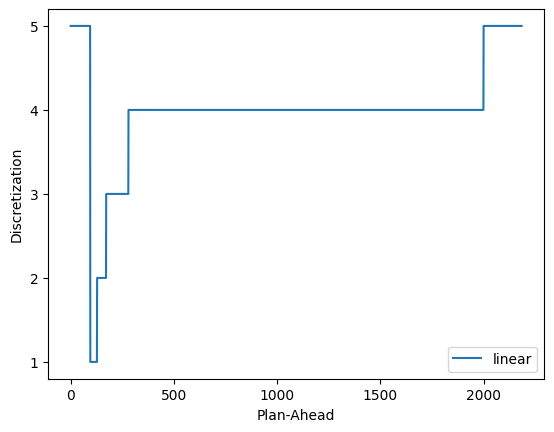

In [149]:
x = list(range(size))
# for predictor_key in predictors:
#     plt.plot(
#         x, get_discretizations(discretizations[predictor_key]), label=predictor_key
#     )
predictor_key = "linear"
plt.plot(x, get_discretizations(discretizations[predictor_key]), label=predictor_key)
plt.xlabel("Plan-Ahead")
plt.ylabel("Discretization")
plt.yticks([1, 2, 3, 4, 5])
plt.legend()

[<matplotlib.lines.Line2D object at 0x7f68242ed3d0>, <matplotlib.lines.Line2D object at 0x7f68242f8670>, <matplotlib.lines.Line2D object at 0x7f6824286910>, <matplotlib.lines.Line2D object at 0x7f6824294bb0>, <matplotlib.lines.Line2D object at 0x7f682429fe50>, <matplotlib.lines.Line2D object at 0x7f68242bc130>, <matplotlib.lines.Line2D object at 0x7f68242493d0>, <matplotlib.lines.Line2D object at 0x7f68242576d0>, <matplotlib.lines.Line2D object at 0x7f6824262970>, <matplotlib.lines.Line2D object at 0x7f6824272c10>, <matplotlib.lines.Line2D object at 0x7f682427feb0>, <matplotlib.lines.Line2D object at 0x7f682421b190>, <matplotlib.lines.Line2D object at 0x7f682422a430>, <matplotlib.lines.Line2D object at 0x7f68242365b0>, <matplotlib.lines.Line2D object at 0x7f68240b5850>, <matplotlib.lines.Line2D object at 0x7f68240c2af0>, <matplotlib.lines.Line2D object at 0x7f68240d1dc0>, <matplotlib.lines.Line2D object at 0x7f68240ef0a0>, <matplotlib.lines.Line2D object at 0x7f682407c340>, <matplotlib

Text(0.5, 0, 'Scheduler invokation')

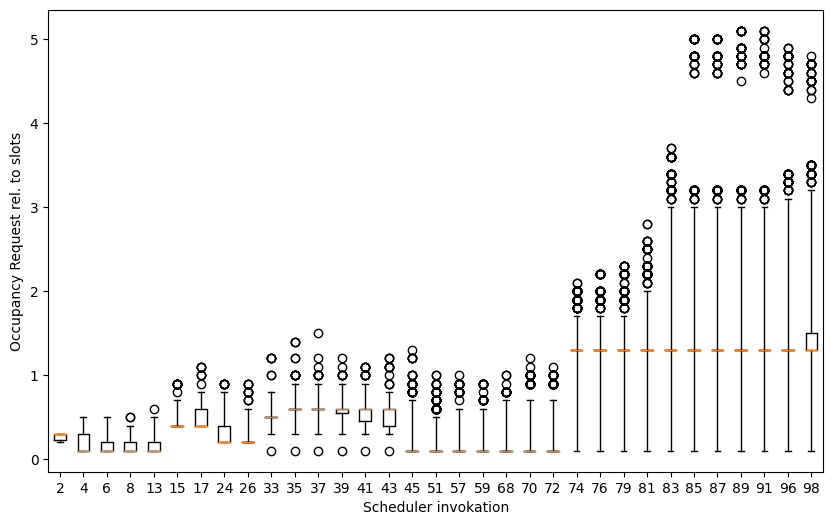

In [8]:
max_demand = 6.0
final_data = []
final_labels = []
plt.figure(figsize=(10, 6))

for i in range(occupancy_map.shape[0]):
    if i < len(scheduler_times):
        # Calculate the CDF
        data = occupancy_map[i] / 10
        sorted_data = np.sort(data)
        if sorted_data[-1] < max_demand:
            # cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

            # # Plot the CDF
            # plt.plot(sorted_data, cdf, label=f"Sched-{scheduler_times[i]}")
            final_data += [data[data != 0]]
            final_labels += [scheduler_times[i]]
    # if i == 5:
    #     break
bb = plt.boxplot(final_data, labels=final_labels, whis=[5, 95])
print(bb["medians"])
# plt.xlabel("Occupancy Request rel. to slots")
# plt.ylabel("Cumulative Probability")
plt.ylabel("Occupancy Request rel. to slots")
plt.xlabel("Scheduler invokation")
# plt.legend()
# plt.show()


# occupancy_map[-3] / 10.0

In [103]:
occupancy_map[21]/10.0

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 11., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  6.,  6.,
        6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5

In [7]:
occupancy_map[-3] / 10.0

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 4.5, 4.5, 4.4, 4.4, 4.4, 4.4, 4.6, 4.6,
       4.6, 4.6, 4.6, 4.6, 4.6, 4.9, 4.9, 4.9, 4.8, 4.8, 4.8, 4.8, 4.8,
       4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.7, 4.7, 4.7, 3.4, 3.4,
       3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4,
       3.4, 3.4, 3.4, 3.4, 3.4, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.2, 3.2,
       3.2, 3.2, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.